# Reinforcement Learning Path-Finder

Todos:
* State representation more compact and independent of room size - maybe rearrange locality by future move reach (diamond shape) and track position as sequence move directions
* Fix back-tracking problem - maybe through move history as above
* Improve visualisation f/w so we can see learning and action values @ each state
* Port to alternative Solver class in open-spacial solution

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# Setup Scenario

In [0]:
def get_room(rank):
  return np.zeros((rank, rank), dtype=int)

def get_random_source(room):
  return random.choice(range(room.shape[0]))

def apply_occupancy(room, ids):
  [room.itemset(i, 1) for i in ids]

def apply_random_occupancy(room, source, p):
  open_desks = list(range(room.size))
  open_desks.remove(source)
  ids = random.sample(open_desks, int(round(p * len(open_desks))))
  apply_occupancy(room, ids)

def generate_random_scenario(rank, p):
  room = get_room(rank)
  source = get_source(room)
  apply_random_occupancy(room, source, p)
  return room, source

def draw_room(room, path=None):
  dr = room.copy()
  if path: [dr.itemset(p, -1) for p in path]
  plt.imshow(dr, vmin=-1, vmax=1, origin='lower')
  plt.show()

# Utility

In [0]:
def i2v(room, i):
  rank = room.shape[0]
  return (i // rank, i % rank)

def v2i(room, v):
  rank = room.shape[0]
  return v[0] * rank + v[1]

def is_front_row(room, i):
  rank = room.shape[0]
  return i // rank == rank - 1

def is_back_row(room, i):
  rank = room.shape[0]
  return i // rank == 0

def is_left_col(room, i):
  rank = room.shape[0]
  return i % rank == 0

def is_right_col(room, i):
  rank = room.shape[0]
  return i % rank == rank - 1

def row_fore(room, i):
  rank = room.shape[0]
  return i + rank

def row_back(room, i):
  rank = room.shape[0]
  return i - rank

def col_left(room, i):
  return i - 1

def col_right(room, i):
  rank = room.shape[0]
  return i + 1

def inbounds(room, v):
  return v[0] >= 0 and v[0] < room.shape[0] and v[1] >= 0 and v[1] < room.shape[1] 

# Environment, Actions and Agent

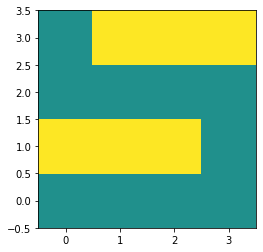

In [4]:
room = get_room(4)
apply_occupancy(room, [4, 5, 6])
apply_occupancy(room, [13, 14, 15])
source = 0

draw_room(room)

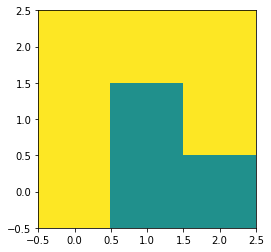

In [5]:
def get_extent(margin):
  return 2 * margin + 1

def get_locality(room, pos, margin):
  o_r = i2v(room, pos)[0] - margin
  o_c = i2v(room, pos)[1] - margin
  extent = get_extent(margin)
  locality = np.zeros((extent, extent), dtype=int)
  for i in range(extent):
    r = o_r + i
    for j in range(extent):
      c = o_c + j
      if inbounds(room, (r, c)):
        locality[i][j] = room[r][c]
      else:
        locality[i][j] = 1
  return locality

loc = get_locality(room, 12, 1)

draw_room(loc)

In [6]:
def get_region_state_id(region):
  rsi = sum([2 ** (region.size - 1 - i) * r for i, r in enumerate(region.flatten())])
  return int(rsi)

print(get_region_state_id(room))
print(get_region_state_id(loc))

3591
303


In [7]:
def get_state_id(room, region, pos):
  region_state_id = get_region_state_id(region)
  return pos + room.size * region_state_id

def get_pos_from_state(room, state):
  return state % room.size

def get_region_from_state(room, state):
  return state // room.size

def one_hot_position(room, pos):
  return np.eye(room.size, dtype=int)[pos]

print(get_state_id(room, loc, 0))

4848


In [0]:
# actions - cardinal directions clockwise from 12 as per problem statement
actions = range(4)

def move_options(room, i):
  blocked = np.zeros(4)
  blocked[0] = is_front_row(room, i) or room.item(row_fore(room, i))
  blocked[1] = is_right_col(room, i) or room.item(col_right(room, i))
  blocked[2] = is_back_row(room, i) or room.item(row_back(room, i))
  blocked[3] = is_left_col(room, i) or room.item(col_left(room, i))
  return np.logical_not(blocked)

move_fn = [row_fore, col_right, row_back, col_left]

# decided to not move anywhere if you try to move through block
# there are alternative ways to do this (eg, more semantic actions, fail)
def next_state(room, margin, state, action):
  i = get_pos_from_state(room, state)
  ni = move_fn[action](room, i) if move_options(room, i)[action] else i
  nloc = get_locality(room, ni, margin)
  return get_state_id(room, nloc, ni)

def is_goal(room, state):
  return is_front_row(room, get_pos_from_state(room, state))

def reward(room, state, action=None, next_state=None):
  r = 0
  if is_goal(room, state):
    r = 1
  return r

# Q-Learning

8192


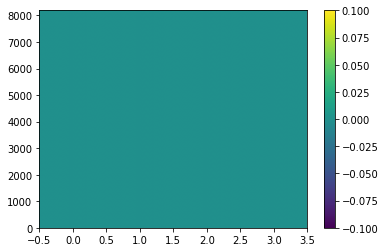

In [43]:
margin = 1
region_size = get_extent(margin) ** 2

room_rank = 4
occ_prop = 0.2

num_states = (2 ** region_size) * room_rank ** 2
print(num_states)

q_table = np.zeros((num_states, len(actions)))

plt.imshow(q_table, origin='lower', aspect='auto')
plt.colorbar()
plt.show()

In [0]:
def action_table(state):
  values = q_table[state]
  return np.argmax(values)

In [0]:
# learning loop

eps = 0.2
alpha = 0.2
gamma = 0.3

episodes = 10000
steps = 50
for n in range(episodes):
  room = get_room(room_rank)
  pos = get_random_source(room)
  apply_random_occupancy(room, pos, occ_prop)
  loc = get_locality(room, pos, margin)
  s = get_state_id(room, loc, pos)
  for t in range(steps):
    # action & reward
    action = random.choice(actions)
    if random.random() > eps:
      action = np.argmax(q_table[s])
    sn = next_state(room, margin, s, action)
    r = reward(room, s, next_state=sn)
    
    if (sn != s or is_goal(room, s)):
      #print('Update q_table for ep {} step {} state {} action {} reward {}'.format(n, t, s, action, r))
      # update q-table
      q_future_est = np.amax(q_table[sn])
      new_val = r + gamma * q_future_est
      old_val = q_table[s][action]
      learning = alpha * (new_val - old_val)
      q_table[s][action] = old_val + learning
      #print('With QFE {} update from {} with {} to {}'.format(q_future_est, old_val, learning, q_table[s][action]))

    # finish or loop
    if is_goal(room, s):
      break
    s = sn



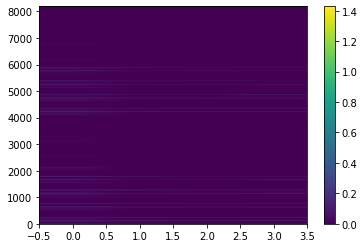

In [45]:
plt.imshow(q_table, origin='lower', aspect='auto')
plt.colorbar()
plt.show()


R? True - path [1, 5, 9, 8, 12]


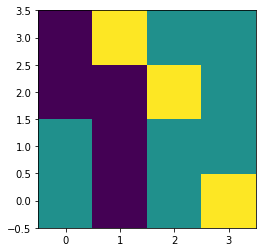

In [55]:
room = get_room(room_rank)
pos = get_random_source(room)
apply_random_occupancy(room, pos, occ_prop)

loc = get_locality(room, pos, margin)
s = get_state_id(room, loc, pos)
path = [get_pos_from_state(room, s)]
for t in range(20):
  a = action_table(s)
  s = next_state(room, margin, s, a) 
  path.append(get_pos_from_state(room, s))
  if is_goal(room, s):
    break

print("R? {} - path {}".format(is_goal(room, s), path))
draw_room(room, path)